# Generative Adversarial Networks in Keras

In [592]:
import xgboost

In [593]:
import tensorflow
import keras
!pip show keras
#print(keras.version)

Name: Keras
Version: 1.2.2
Summary: Deep Learning for Python
Home-page: https://github.com/fchollet/keras
Author: Francois Chollet
Author-email: francois.chollet@gmail.com
License: MIT
Location: /home/ubuntu/anaconda3/lib/python3.6/site-packages
Requires: theano, pyyaml, six


In [594]:
import matplotlib
%matplotlib inline
import numpy as np
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

from tqdm import tqdm

## The original GAN!

See [this paper](https://arxiv.org/abs/1406.2661) for details of the approach we'll try first for our first GAN. We'll see if we can generate hand-drawn numbers based on MNIST, so let's load that dataset first.

We'll be refering to the discriminator as 'D' and the generator as 'G'.

In [595]:
#keras tutorial if needed
#https://elitedatascience.com/keras-tutorial-deep-learning-in-python#step-4
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train.shape

(60000, 28, 28)

In [596]:
n = len(X_train)

In [597]:
X_train = X_train.reshape(n, -1).astype(np.float32)
X_test = X_test.reshape(len(X_test), -1).astype(np.float32)

In [598]:
X_train /= 255.; X_test /= 255.

In [599]:
# this must be the train images
print (X_train.shape)

(60000, 784)


In [600]:
# this could be the test images
print (X_test.shape)

(10000, 784)


In [601]:
# this must be the labels for the 60k images
print (y_train.shape)

(60000,)


## Train

This is just a helper to plot a bunch of generated images.

In [602]:
def plot_gen(G, n_ex=16):
    plot_multi(G.predict(noise(n_ex)).reshape(n_ex, 28,28), cmap='gray')

Create some random data for the generator.

In [603]:
def noise(bs): return np.random.rand(bs,100)

Create a batch of some real and some generated data, with appropriate labels, for the discriminator.

In [604]:
#print(128//2) # the // makes it an integer
#print(n)
#print(np.random.randint(0,n,size=128//2))
#print(np.random.randint(0,n,size=128//2).shape)

# given random image from 0 to 60k
#print(X_train[np.random.randint(0,n,size=128//2)])
print(X_train.shape)
#plt.imshow(X_train[30000][2])

szt = 4
# this creates a 1D vector. 4 zeros and 4 ones
print([0]*szt + [1]*szt)

# reason it looks odd is because we flatten it.
#imgplot = plt.imshow(X_train[np.random.randint(0,n,size=128//2)])
#imgplot = plt.imshow(X_train[np.random.randint(0,n,size=128//2)])

(60000, 784)
[0, 0, 0, 0, 1, 1, 1, 1]


In [605]:
def data_D(sz, G):
    # get real image. the real image here is flattened.
    real_img = X_train[np.random.randint(0,n,size=sz)]
    # get fake image from generator
    X = np.concatenate((real_img, G.predict(noise(sz))))
    # return fake + real image, 
    return X, [0]*sz + [1]*sz

In [606]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers: l.trainable = val

Train a few epochs, and return the losses for D and G. In each epoch we:

1. Train D on one batch from data_D()
2. Train G to create images that the discriminator predicts as real.

In [607]:
# train on half real half fake images
def train(D, G, m, nb_epoch=5000, bs=128):
    dl,gl=[],[]
    for e in tqdm(range(nb_epoch)):
        # data_D. Is for the discriminator
        # Inputs:  an image from the geneator , size of image
        # Outputs: binary is the image real or fake?
        # returns real + fake image, labels of real(0) and fake(1) images
        X,y = data_D(bs//2, G)
        dl.append(D.train_on_batch(X,y))
        make_trainable(D, False)
        gl.append(m.train_on_batch(noise(bs), np.zeros([bs])))
        #gl.append(m.train_on_batch(noise(bs), np.zeros([bs])))
        make_trainable(D, True)
    return dl,gl

## MLP GAN

We'll keep thinks simple by making D & G plain ole' MLPs.

In [608]:
MLP_G = Sequential([
    Dense(200, input_shape=(100,), activation='relu'),
    Dense(400, activation='relu'),
    Dense(784, activation='sigmoid'),
])

In [609]:
MLP_D = Sequential([
    Dense(300, input_shape=(784,), activation='relu'),
    Dense(300, activation='relu'),
    Dense(1, activation='sigmoid'),
])
MLP_D.compile(Adam(1e-4), "binary_crossentropy")

In [610]:
MLP_m = Sequential([MLP_G,MLP_D])
# this i think is the loss function that we want to minimize. I think i sort of get it
# see compile here https://keras.io/
MLP_m.compile(Adam(1e-4), "binary_crossentropy")

In [611]:
#dl,gl = train(MLP_D, MLP_G, 4000)
dl,gl = train(MLP_D, MLP_G, MLP_m, 50)
#dl,gl = train(MLP_D, MLP_G, MLP_m, 4000)

100%|██████████| 50/50 [00:04<00:00, 10.55it/s]


The loss plots for most GANs are nearly impossible to interpret - which is one of the things that make them hard to train.

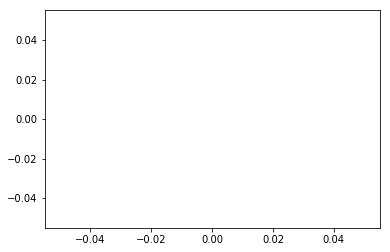

In [612]:
# loss at each step
# are these good or bad?
plt.plot(dl[100:])

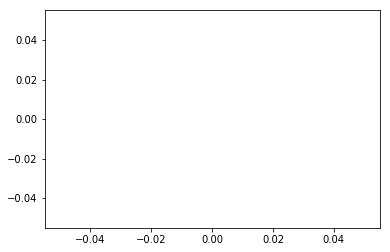

In [613]:
plt.plot(gl[100:])

This is what's known in the literature as "mode collapse".

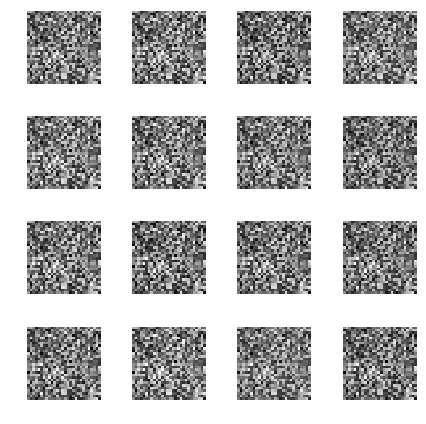

In [614]:
# this explains mode collapse
# https://www.quora.com/Whats-kind-of-generative-result-means-mode-collapse-in-Generative-adversarial-networks
# very little diversity
# seems to be explained when the " Generator" maps random noise to the same input image?

#plot_gen()
plot_gen(MLP_G)
# generator and discriminator have reached a stale mate

In [615]:
#plot_gen(MLP_D)
#plot_gen(MLP_G)
#plot_gen(MLP_G)

OK, so that didn't work. Can we do better?...

## DCGAN

There's lots of ideas out there to make GANs train better, since they are notoriously painful to get working. The [paper introducing DCGANs](https://arxiv.org/abs/1511.06434) is the main basis for our next section. Add see https://github.com/soumith/ganhacks for many tips!

Because we're using a CNN from now on, we'll reshape our digits into proper images.

In [616]:
X_train = X_train.reshape(n, 28, 28, 1)
X_test = X_test.reshape(len(X_test), 28, 28, 1)

Our generator uses a number of upsampling steps as suggested in the above papers. We use nearest neighbor upsampling rather than fractionally strided convolutions, as discussed in our style transfer notebook.

In [617]:
CNN_G = Sequential([
    #Dense(512*7*7, input_dim=100, activation=LeakyReLU()),
    Dense(128*7*7, input_dim=100, activation=LeakyReLU()),
    BatchNormalization(mode=2),
    #BatchNormalization(),
    #Reshape((7, 7, 512)),
    Reshape((7, 7, 128)),
    UpSampling2D(),
    # this means 64 filters, each filter has size of 3 by 3
    #Convolution2D(64, 3, 3, border_mode='same', activation=LeakyReLU()),
    Convolution2D(64, 5, 5, border_mode='same', activation=LeakyReLU()),
    BatchNormalization(mode=2),
    #BatchNormalization(),
    UpSampling2D(),
    #Convolution2D(32, 3, 3, border_mode='same', activation=LeakyReLU()),
    #BatchNormalization(mode=2),
    #BatchNormalization(),
    Convolution2D(1, 5, 5, border_mode='same', activation='sigmoid')
])

In [618]:
def initNormal(shape, name=None):
    return initializations.normal(shape, scale=0.02, name=name)

In [619]:
# for some reasons this has a different output shape

#CNN_G = Sequential()
#CNN_G.add(Dense( input_dim=100, output_dim=(128*7*7), init=initNormal))
#CNN_G.add(Activation('relu'))
#CNN_G.add(Reshape((128, 7, 7)))	
#CNN_G.add(UpSampling2D(size=(2, 2)))
#CNN_G.add(Convolution2D(64, 5, 5, border_mode='same'))
#CNN_G.add(Activation('relu')
#CNN_G.add(UpSampling2D(size=(2, 2)))
#CNN_G.add(Convolution2D(1, 5, 5, border_mode='same'))
#CNN_G.add(Activation('tanh'))
#generator.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [620]:
CNN_G.summary()
# compare this against just GAN. without deep convolutional
#MLP_G = Sequential([
#    Dense(200, input_shape=(100,), activation='relu'),
#    Dense(400, activation='relu'),
#    Dense(784, activation='sigmoid'),
#])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_123 (Dense)                (None, 6272)          633472      dense_input_48[0][0]             
____________________________________________________________________________________________________
batchnormalization_36 (BatchNorm (None, 6272)          25088       dense_123[0][0]                  
____________________________________________________________________________________________________
reshape_21 (Reshape)             (None, 7, 7, 128)     0           batchnormalization_36[0][0]      
____________________________________________________________________________________________________
upsampling2d_37 (UpSampling2D)   (None, 14, 14, 128)   0           reshape_21[0][0]                 
___________________________________________________________________________________________

The discriminator uses a few downsampling steps through strided convolutions.

In [621]:
CNN_D = Sequential()
#CNN_D.add(Convolution2D(64, 5, 5, border_mode='same', subsample=(2,2), input_shape=(1,28,28), init=initNormal))
CNN_D.add(Convolution2D(64, 5, 5, border_mode='same', subsample=(2,2), input_shape=(28,28,1)))
CNN_D.add(LeakyReLU(0.2))
CNN_D.add(Convolution2D(128, 5, 5, border_mode='same', subsample=(2,2)))
CNN_D.add(LeakyReLU(0.2))
CNN_D.add(Flatten())
CNN_D.add(Dense(1))
CNN_D.add(Activation('sigmoid'))

CNN_D.compile(Adam(1e-3), "binary_crossentropy")
    #discriminator.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [622]:
#CNN_D = Sequential([
#    # see the input shape here, why doesnt it have to match the generator? i.e (1,1,1)?
#    Convolution2D(256, 5, 5, subsample=(2,2), border_mode='same', 
#                  input_shape=(28, 28, 1), activation=LeakyReLU()),
    # it doubles filters where prior it reduces filters
    # what is the impact of doubling or increasing filters?
    # wish i could see what the layers look likt?
    # also may be helpful to draw out the architecture
#    Convolution2D(512, 5, 5, subsample=(2,2), border_mode='same', activation=LeakyReLU()),
#    Flatten(),
#    Dense(256, activation=LeakyReLU()),
#    # this layer is the same
#    Dense(1, activation = 'sigmoid')
#])

#CNN_D.compile(Adam(1e-3), "binary_crossentropy")

In [623]:
#MLP_D = Sequential([
#    Dense(300, input_shape=(784,), activation='relu'),
#    Dense(300, activation='relu'),
#    Dense(1, activation='sigmoid'),
#])
#MLP_D.compile(Adam(1e-4), "binary_crossentropy")

We train D a "little bit" so it can at least tell a real image from random noise.

In [624]:
sz = n//200
#sz = n//50
print(sz)
x1 = np.concatenate([np.random.permutation(X_train)[:sz], CNN_G.predict(noise(sz))])
CNN_D.fit(x1, [0]*sz + [1]*sz, batch_size=128, nb_epoch=1, verbose=2)

300
Epoch 1/1
1s - loss: 0.5361


(150, 28, 28, 1)
(300, 28, 28, 1)
(300, 28, 28, 1)


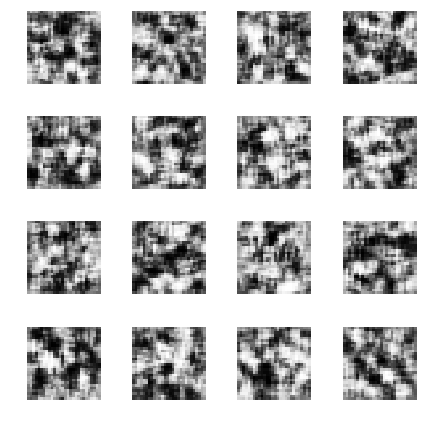

In [625]:
#this works
#test_results = CNN_G.predict(noise(sz))
print(test_results.shape)

test_real_image = np.random.permutation(X_train)[:sz]
print(test_real_image.shape)

test_results_old = CNN_G_test.predict(noise(sz))
print(test_results_old.shape)

plot_gen(CNN_G)

In [626]:
CNN_m = Sequential([CNN_G, CNN_D])
CNN_m.compile(Adam(1e-4), "binary_crossentropy")

In [627]:
#K.set_value(CNN_D.optimizer.lr, 1e-3)
#K.set_value(CNN_m.optimizer.lr, 1e-3)

K.set_value(CNN_D.optimizer.lr, 2e-4)
K.set_value(CNN_m.optimizer.lr, 2e-4)

Now we can train D & G iteratively.

In [628]:
#tbCallBack = keras.callbacks.TensorBoard(log_dir='/Graph', 
 #                                        histogram_freq=0, write_graph=True, write_images=True)

In [629]:
#dl,gl = train(CNN_D, CNN_G, CNN_m, 250)
#dl,gl = train(CNN_D, CNN_G, CNN_m, 500)
#dl,gl = train(CNN_D, CNN_G, CNN_m, 2500)
dl,gl = train(CNN_D, CNN_G, CNN_m, 500)

100%|██████████| 500/500 [00:36<00:00, 13.53it/s]


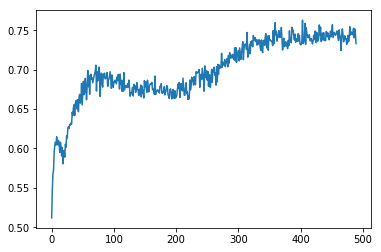

In [630]:
#print(dl)
plt.plot(dl[10:])

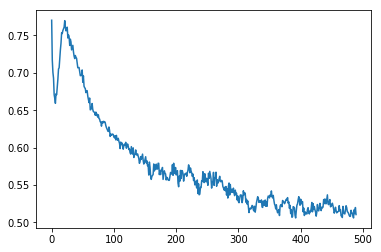

In [631]:
plt.plot(gl[10:])

Better than our first effort, but still a lot to be desired:...

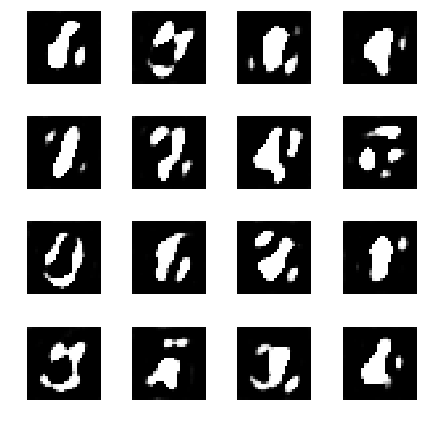

In [632]:
plot_gen(CNN_G)
# very rough can see a 5
# but still not so good

## End

Below is attempt to visualize the filters. The goal is visualize the filters may help to understand the CNN better

In [633]:
# this is soooo coool. I get to understand what the model looks like
# this shows me the architecture
CNN_D.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_77 (Convolution2D) (None, 14, 14, 64)    1664        convolution2d_input_15[0][0]     
____________________________________________________________________________________________________
leakyrelu_65 (LeakyReLU)         (None, 14, 14, 64)    0           convolution2d_77[0][0]           
____________________________________________________________________________________________________
convolution2d_78 (Convolution2D) (None, 7, 7, 128)     204928      leakyrelu_65[0][0]               
____________________________________________________________________________________________________
leakyrelu_66 (LeakyReLU)         (None, 7, 7, 128)     0           convolution2d_78[0][0]           
___________________________________________________________________________________________

In [634]:
# this gets the weights
#CNN_D.get_weights()

In [635]:
CNN_D.layers

In [636]:
CNN_D.layers

<class 'numpy.ndarray'>
784
(1, 28, 28)
784
(1, 28, 28, 1)


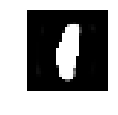

In [637]:
input_img = CNN_G.predict(noise(1)).reshape(1, 28,28)
input_img_raw = CNN_G.predict(noise(1))

plot_multi(CNN_G.predict(noise(1)).reshape(1, 28,28), cmap='gray')

print(type(input_img))
print(input_img.size)
print(input_img.shape)
print(input_img_raw.size)
print(input_img_raw.shape)
plt.imshow(input_img[0], cmap='gray')

In [638]:
from keras import backend as K

layer_dict = dict([(layer.name, layer) for layer in CNN_D.layers])
#input_img = CNN_G.predict(noise(1)).reshape(1, 28,28)[0]
input_img = CNN_G.predict(noise(1)).reshape(1, 28,28)
#plt.imshow(input_img, cmap='gray')

layer_name = 'convolution2d_4'
filter_index = 2  # can be any integer from 0 to 511, as there are 512 filters in that layer

# build a loss function that maximizes the activation
# of the nth filter of the layer considered
layer_output = layer_dict[layer_name].output
print(layer_output)

loss = K.mean(layer_output[:, :, :, filter_index])
print(loss)

# compute the gradient of the input picture wrt this loss
print(K.gradients(loss, input_img))
grads = K.gradients(loss, input_img)[0]
print(grads)

# normalization trick: we normalize the gradient
#grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

# this function returns the loss and grads given the input picture
#iterate = K.function([input_img], [loss, grads])

KeyError: 'convolution2d_4'

In [ ]:
# utility functions
from mpl_toolkits.axes_grid1 import make_axes_locatable

def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None):
    """Wrapper around pl.imshow"""
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cmap)
    pl.colorbar(im, cax=cax)

In [ ]:
# this plots the image
import pylab as pl
import matplotlib.cm as cm
#i = 4600
i = 1000

# Visualize the first layer of convolutions on an input image
X = X_test[i:i+1]

pl.figure()
pl.title('input')
nice_imshow(pl.gca(), np.squeeze(X), vmin=0, vmax=1, cmap=cm.binary)

In [ ]:
# this plots the weights
# I can do it for the first layer kind of wanted to see it for the other layers

import numpy.ma as ma
def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[0]
    imshape = imgs.shape[1:]
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in range(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[i]
    return mosaic

#pl.imshow(make_mosaic(np.random.random((9, 10, 10)), 3, 3, border=1))

In [ ]:
# Visualize weights
# this plots the weights
# I can do it for the first layer kind of wanted to see it for the other layers
print(CNN_D.layers[0])

#test = CNN_D.get_weights()[0]
#print(type(test))
#print(test.shape)
print(CNN_D.get_weights()[0].shape)
print(CNN_D.get_weights()[1].shape)
print(CNN_D.get_weights()[2].shape)
print(CNN_D.get_weights()[3].shape)

W = CNN_D.get_weights()[0]
#W = CNN_D.layers[0].W.get_value(borrow=True)
W = np.squeeze(W)
W= W.reshape(5,256,5)
print("W shape : ", W.shape)

pl.figure(figsize=(15, 15))
pl.title('conv1 weights')
nice_imshow(pl.gca(), W[1], vmin=0, vmax=1, cmap=cm.binary)
#nice_imshow(pl.gca(), make_mosaic(W, 4,4), cmap=cm.binary)